### Cab-Driver Agent

In [9]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import warnings

# for building DQN model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

warnings.filterwarnings('ignore')

#### Defining Time Matrix

In [10]:
# Loading the time matrix provided
time_matrix = np.load("TM.npy").astype(int)

#### Tracking the state-action pairs for checking convergence

In [11]:
# Initialise Q_dictionary as 'Q_dict' for convergence
Q_dict = collections.defaultdict(dict)

In [12]:
# Define a function to update the Q table
def update_q_table(state, action, q_val):
    if state not in Q_dict:
        Q_dict[state] = {}
    if action not in Q_dict[state]:
        Q_dict[state][action] = []
    Q_dict[state][action].append(q_val)

In [13]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

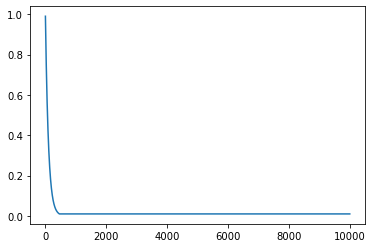

In [14]:
# Experimenting with epsilon decay
epsilon = 1
epsilon_decay = 0.99
epsilon_min = 0.01
episodes = np.arange(0, 10000)
epsilon_arr = []
for i in episodes:
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    epsilon_arr.append(epsilon)

plt.plot(episodes, epsilon_arr)
plt.show()

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters for the DQN
        self.discount_factor = 0.85
        self.learning_rate = 0.05
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.batch_size = 64
        
        # create replay memory using deque
        self.memory = deque(maxlen=5000)

        # create main model and target model
        self.model = self.build_model()
        
        # Initialize MSE to track model losses
        self.mse = tf.keras.losses.MeanSquaredError()


    # Approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def get_action(self, state):
        # Get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        possible_actions = env.requests(state)
        if np.random.rand() > self.epsilon: # Exploitation
            state_enc = env.state_encod_arch2(state)
            state_enc = state_enc.reshape(1, self.state_size)
            q_val = self.model.predict(state_enc)
            action = env.action_space[np.argmax(q_val[0])]
            action_type = 1
        else: # Exploration
            action = random.choice(possible_actions)
            action_type = 2
        return action, action_type
    

    def append_sample(self, state, action, reward, next_state, is_terminal):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, is_terminal))
    

    # Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size), dtype=int)
            update_output = np.zeros((self.batch_size, self.state_size), dtype=int)
            actions, rewards, terminal = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, is_terminal = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)
                update_output[i] = env.state_encod_arch2(next_state)
                actions.append(action)
                rewards.append(reward)
                terminal.append(is_terminal)
                
            target = self.model.predict(update_input)
            y_pred = target.copy()
            # Get the target for the Q-network
            q_vals = self.model.predict(update_output)
            
            for i in range(self.batch_size):
                action_index = env.action_space.index(actions[i])
                update_q_table(tuple(update_input[i]), actions[i], target[i][action_index])
                if terminal[i]:
                    # Terminal state
                    target[i][action_index] = rewards[i]
                else:
                    # Non-terminal state
                    target[i][action_index] = rewards[i] + self.discount_factor * np.max(q_vals[i])
                
                                    
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return self.mse(target, y_pred).numpy() # updated target becomes y_true and the model prediction from current state becomes y_pred


    def save(self, name):
        self.model.save_weights(name)

### DQN block

In [16]:
Episodes = 10000
env = CabDriver()
agent = DQNAgent(env.state_size, env.action_size)
average_rewards = []
total_losses = []
rewards_per_n_episode = 0
track_n = 50 # Number of episodes interval to track
for episode in range(Episodes):
    is_terminal = False
    action_space, state_space, state = env.reset()
    loss_per_episode = 0
    exploit = 0
    explore = 0
    count = 0
    while not is_terminal:
        count += 1
        action, action_type = agent.get_action(state)
        reward = env.get_reward(state, action, time_matrix)
        next_state, is_terminal = env.get_next_state(state, action, time_matrix)
        agent.append_sample(state, action, reward, next_state, is_terminal)
        rewards_per_n_episode += reward
        state = next_state
    
        # Train the model
        if count % 50 == 0:
            loss = agent.train_model()
            if loss:
                loss_per_episode += loss
            
        if action_type == 1:
            exploit += 1
        else:
            explore += 1
       
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    
    total_losses.append(loss_per_episode)
    
    # Keep a track of rewards, and loss
    if episode % track_n == 0:
        average_rewards.append(rewards_per_n_episode / track_n)
        print('Episode: {} -> Average Reward: {} -> Exploit: {} -> Explore: {} -> Epsilon: {}'.format(episode, average_rewards[len(average_rewards)-1], exploit, explore, agent.epsilon))
        rewards_per_n_episode = 0

    if episode % 500 == 0:
        agent.save('episode_{0}.h5'.format(str(episode)))

# Save the final model weights after the completion of all episodes
agent.save('episode_final.h5')

Episode: 0 -> Average Reward: -3.38 -> Exploit: 0 -> Explore: 147 -> Epsilon: 0.99
Episode: 50 -> Average Reward: -29.88 -> Exploit: 59 -> Explore: 98 -> Epsilon: 0.5989560064661611
Episode: 100 -> Average Reward: 934.86 -> Exploit: 66 -> Explore: 49 -> Epsilon: 0.36237201786049694
Episode: 150 -> Average Reward: 1462.22 -> Exploit: 106 -> Explore: 34 -> Epsilon: 0.21923726936647234
Episode: 200 -> Average Reward: 1939.08 -> Exploit: 113 -> Explore: 13 -> Epsilon: 0.13263987810938213
Episode: 250 -> Average Reward: 2302.38 -> Exploit: 116 -> Explore: 5 -> Epsilon: 0.08024793100055952
Episode: 300 -> Average Reward: 2384.3 -> Exploit: 114 -> Explore: 5 -> Epsilon: 0.0485504851305729
Episode: 350 -> Average Reward: 2454.42 -> Exploit: 119 -> Explore: 3 -> Epsilon: 0.029373338066467324
Episode: 400 -> Average Reward: 2493.04 -> Exploit: 132 -> Explore: 4 -> Epsilon: 0.017771047742294682
Episode: 450 -> Average Reward: 2574.78 -> Exploit: 106 -> Explore: 0 -> Epsilon: 0.010751591703479106


Episode: 4000 -> Average Reward: 2552.34 -> Exploit: 99 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 4050 -> Average Reward: 2526.5 -> Exploit: 106 -> Explore: 0 -> Epsilon: 0.009920974201040588
Episode: 4100 -> Average Reward: 2512.12 -> Exploit: 100 -> Explore: 0 -> Epsilon: 0.009920974201040588
Episode: 4150 -> Average Reward: 2570.96 -> Exploit: 102 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 4200 -> Average Reward: 2481.96 -> Exploit: 104 -> Explore: 0 -> Epsilon: 0.009920974201040588
Episode: 4250 -> Average Reward: 2550.74 -> Exploit: 106 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 4300 -> Average Reward: 2534.28 -> Exploit: 101 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 4350 -> Average Reward: 2527.08 -> Exploit: 102 -> Explore: 0 -> Epsilon: 0.009920974201040588
Episode: 4400 -> Average Reward: 2484.14 -> Exploit: 101 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 4450 -> Average Reward: 2508.94 -> Exploit: 97 -> Explore

Episode: 8000 -> Average Reward: 2519.98 -> Exploit: 114 -> Explore: 2 -> Epsilon: 0.009920974201040588
Episode: 8050 -> Average Reward: 2548.26 -> Exploit: 105 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 8100 -> Average Reward: 2558.28 -> Exploit: 103 -> Explore: 3 -> Epsilon: 0.009920974201040588
Episode: 8150 -> Average Reward: 2443.5 -> Exploit: 106 -> Explore: 2 -> Epsilon: 0.009920974201040588
Episode: 8200 -> Average Reward: 2469.02 -> Exploit: 103 -> Explore: 2 -> Epsilon: 0.009920974201040588
Episode: 8250 -> Average Reward: 2598.84 -> Exploit: 103 -> Explore: 4 -> Epsilon: 0.009920974201040588
Episode: 8300 -> Average Reward: 2552.18 -> Exploit: 109 -> Explore: 2 -> Epsilon: 0.009920974201040588
Episode: 8350 -> Average Reward: 2525.14 -> Exploit: 103 -> Explore: 1 -> Epsilon: 0.009920974201040588
Episode: 8400 -> Average Reward: 2536.5 -> Exploit: 106 -> Explore: 0 -> Epsilon: 0.009920974201040588
Episode: 8450 -> Average Reward: 2502.9 -> Exploit: 112 -> Explore

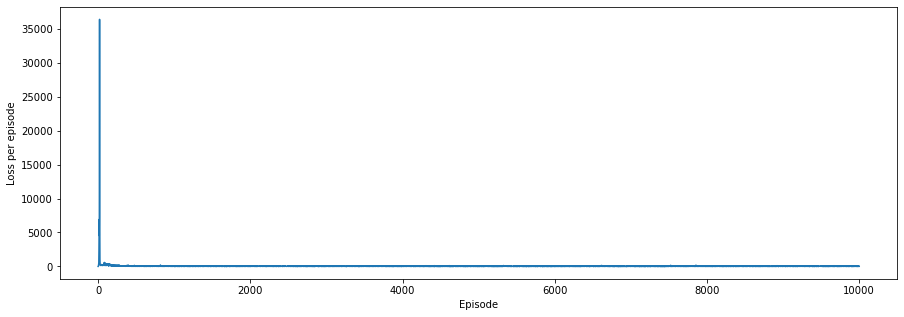

In [17]:
plt.figure(figsize=(15,5))
plt.plot(list(range(len(total_losses))), total_losses)
plt.xlabel("Episode")
plt.ylabel("Loss per episode")
plt.show()

**Observations:** As the agent learns, the losses decrease

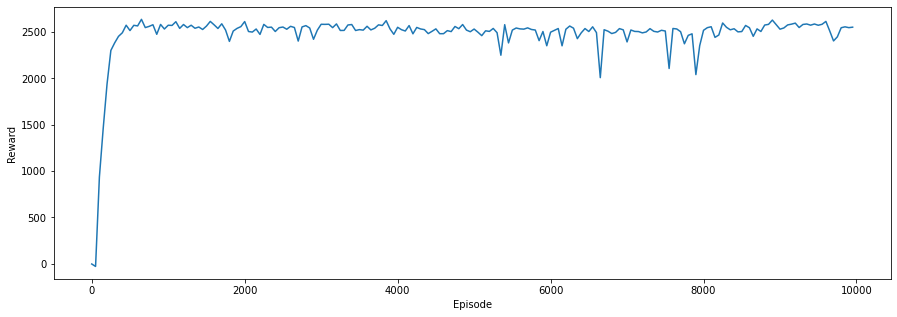

In [18]:
plt.figure(figsize=(15,5))
plt.plot((np.array(range(len(average_rewards))) * track_n), average_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

### Tracking Convergence
#### Check the states tracked for Q-values convergence
Lets check couple state actions from Q-Dict table and see how well the q-value for those state action has converged

In [19]:
def average_list_elem(li, no_elem):
    return_list = []
    su = 0
    count = 1
    for e in li:
        if no_elem == count:
            return_list.append(su / no_elem)
            su = 0
            count = 1
        su += e
        count +=1
    if su != 0:
        return_list.append(su/count)
    return return_list

State: (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0) 
Action: (2, 3)


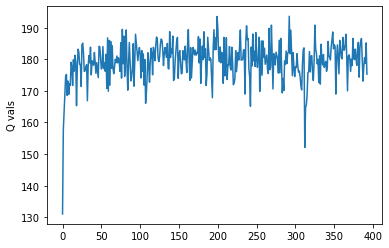

State: (0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 
Action: (2, 3)


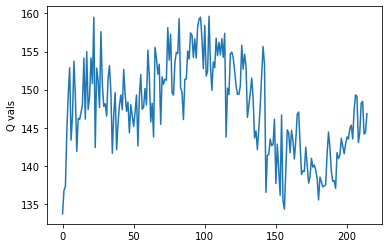

State: (0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0) 
Action: (2, 3)


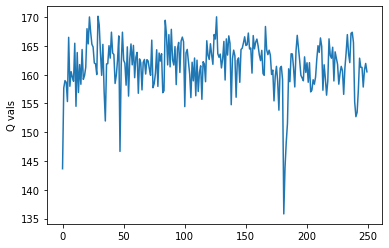

In [20]:
count = 0
outer_keys = Q_dict.keys()
for key in outer_keys:
    inner_keys = Q_dict[key].keys()
    for inner_key in inner_keys:
        if len(Q_dict[key][inner_key]) > 10000:
            print('State:', key , '\nAction:', inner_key)
            plt.plot(average_list_elem(Q_dict[key][inner_key], 50))
            plt.ylabel('Q vals')
            plt.show()
            count += 1
            if count >= 3:
                break
    if count >= 3:
        break

**Observations**: The Q values gradually converges after some point of time

In [21]:
# Saving Q values in a pickle file
save_obj(Q_dict, 'Q_dict')